# Unbiased and Biased KM Estimater 

/tmp/ipykernel_157287/906318649.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


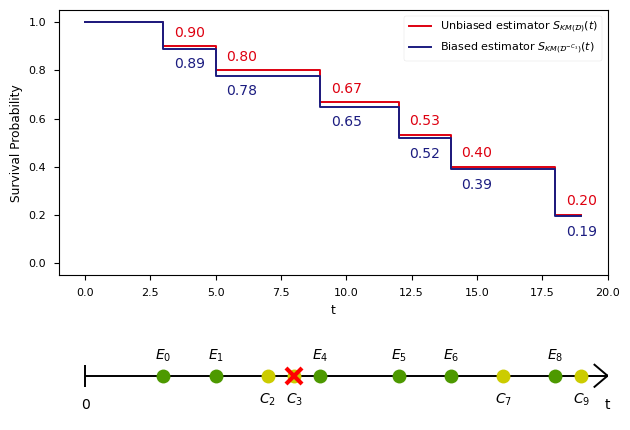

In [1]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

plt.style.use('seaborn-paper')
# The figure to illustrate the relationship between unbiased estimator and biased estimator
t = [3, 5, 7, 8, 9, 12, 14, 16, 18, 19]
e = [1, 1, 0, 0, 1, 1, 1, 0, 1, 0]
expt_idx = 3
t_expt = t.copy()
e_expt = e.copy()
t_expt.pop(expt_idx)
e_expt.pop(expt_idx)

km_unbias = KaplanMeierFitter()
km_unbias.fit(t, event_observed=e)
time_bins = km_unbias.survival_function_.index.values
survival_curves = km_unbias.survival_function_.KM_estimate.values

km_bias = KaplanMeierFitter()
km_bias.fit(t_expt, e_expt)
time_bins_expt = km_bias.survival_function_.index.values
survival_curves_expt = km_bias.survival_function_.KM_estimate.values

xmin = 0
xlim = time_bins.max()

# set up the figure
fig, (ax1, ax3) = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]})
ax1.step(time_bins, survival_curves, where='post', label=r'Unbiased estimator $S_{KM(\mathcal{D})} (t)$', color='#de0010')
for i in range(1, len(time_bins)):
    if e[i-1] == 1:
        ax1.annotate('{:.2f}'.format(survival_curves[i]), (time_bins[i],survival_curves[i]), xytext = (time_bins[i] + 1, survival_curves[i] + 0.04), horizontalalignment='center', c='#de0010')
ax1.step(time_bins_expt, survival_curves_expt, where='post', label=r'Biased estimator $S_{KM(\mathcal{D}^{-C_3})} (t )$', color='#1b1c80')
for i in range(1, len(time_bins_expt)):
    if e_expt[i-1] == 1:
        ax1.annotate('{:.2f}'.format(survival_curves_expt[i]), (time_bins_expt[i],survival_curves_expt[i]), xytext = (time_bins_expt[i] + 1, survival_curves_expt[i] - 0.08), horizontalalignment='center', c='#1b1c80')

ax1.set_xlabel('t')
ax1.set_ylabel('Survival Probability')
# ax1.set_title(r'Unbiased estimator $S_{KM} (t | \mathcal{D})$')
ax1.legend()
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlim(xmin - 1,xlim + 1)

# ax2.plot(time_bins_expt, survival_curves_expt)
# for i in range(1, len(time_bins_expt)):
#     if e_expt[i-1] == 1:
#         ax2.annotate('{:.2f}'.format(survival_curves_expt[i]), (time_bins_expt[i],survival_curves_expt[i]), xytext = (time_bins_expt[i],survival_curves_expt[i] - 0.2), horizontalalignment='center', c='#2878B5')
# ax2.set_xlabel('t')
# ax2.set_ylabel('Survival Probability')
# ax2.set_title(r'Biased estimator $S_{KM} (t | \mathcal{D}^{-C_{4}})$')

ax3.set_xlim(xmin - 1,xlim + 1)
ax3.set_ylim(-2,2)

# draw lines
y = 0
height = 1

ax3.hlines(y, xmin, xlim + 1, color='black')
ax3.vlines(xmin, y - height / 2., y + height / 2., color='black')
x_pos = [xlim + 1 - height / 2., xlim + 1]
upper_arrow = [height / 2., 0]
lower_arrow = [-height / 2., 0]
ax3.plot(x_pos, upper_arrow, color='black')
ax3.plot(x_pos, lower_arrow, color='black')

for i in range(len(t)):
    # draw a point on the line
    px = t[i]
    if e[i] == 1:
        color = '#4D9900'
        name = r'$E_{}$'.format(i)
        position = 0.75
    else:
        color = '#CCCC00'
        name = r'$C_{}$'.format(i)
        position = -1.25
    ax3.plot(px, y, 'ro', ms = 10, mfc = color, markeredgecolor = 'black')

    # add an arrow
    ax3.annotate(name, (px,y), xytext = (px, y + position),
                  horizontalalignment='center')

ax3.plot(t[expt_idx], y, 'x', ms= 12, markeredgewidth=3, mfc = 'red', markeredgecolor = 'red')
# add numbers
ax3.text(xmin, y-1.5, '0', horizontalalignment='center')
ax3.text(xlim+1, y-1.5, 't', horizontalalignment='center')
ax3.axis('off')

plt.tight_layout()
# plt.show()
plt.savefig('Figs/illustration/example_unbias_bias_estimator.pdf', dpi=400)

# Plot illustration for six different evaluation metrics

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz
import math
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as mlines

# import matplotlib.image as image
# from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
#
# death_img_file = "Figs/illustration/death.png"
# death_img = image.imread(death_img_file)
# death_imagebox = OffsetImage(death_img, zoom = 0.02)

color_list = sns.color_palette("deep", 6)


plt.style.use('seaborn-paper')
plt.rcParams["figure.figsize"] = (10, 5)
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title

plt.rcParams['font.size'] = 12

def weibull_pdf(x, scale, shape):
    return (shape / scale) * (x / scale)**(shape - 1) * np.exp(-(x / scale)**shape)

def gamma_pdf(x, scale, shape):
    return (x ** (shape - 1) * np.exp(-x / scale)) / (math.gamma(shape) * scale ** shape)

def lognormal_pdf(x, mu, sigma):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))

def heaviside(x, time):
    function = np.zeros_like(x)
    function[x < time] = 1
    return function

e_1 = 1.5
e_2 = 1.8
e_3 = 0.8
e_4 = 2.15
end_time = 3
N = 100000
s1 = 0.5 * np.random.weibull(a=1, size=int(0.4*N))   # generate your data sample with N elements
s2 = 2.8 * np.random.weibull(a=7, size=int(0.6*N))
sample_all = np.append(s1, s2)
kde = gaussian_kde(sample_all)
# these are the values over which your kernel will be evaluated
dist_space = np.arange(0, end_time, 0.001)
p_1 = kde(dist_space)
# plt.plot( dist_space, pdf )
cdf_1 = cumtrapz(p_1, dist_space, initial=0)
death_idx_1 = int(e_1/0.001)
# ab_1 = AnnotationBbox(death_imagebox, (e_1, 1 - cdf_1[death_idx_1]), frameon = False)

p_2 = weibull_pdf(dist_space, 1.1, 2)
cdf_2 = cumtrapz(p_2, dist_space, initial=0)
death_idx_2 = int(e_2/0.001)
p_3 = gamma_pdf(dist_space, 0.6, 3)
cdf_3 = cumtrapz(p_3, dist_space, initial=0)
death_idx_3 = int(e_3/0.001)
p_4 = lognormal_pdf(dist_space, 0.7, 0.2)
p_4[0] = 0
cdf_4 = cumtrapz(p_4, dist_space, initial=0)
death_idx_4 = int(e_4/0.001)


fig, axes = plt.subplots(nrows=2, ncols=3)

# subfigure 0, l1 loss
axes[0, 0].axhline(0.5, ls='dashdot', c='grey')
axes[0, 0].axvline(e_1, ls='--', c=color_list[0], alpha=0.5)
axes[0, 0].axvline(dist_space[np.where(cdf_1 > 0.5)[0][0]], ls='--', c=color_list[0], alpha=0.5)
axes[0, 0].plot(dist_space, 1 - cdf_1, label='Patient A', c=color_list[0])
axes[0, 0].plot(e_1, 1 - cdf_1[death_idx_1], marker='*', markersize=12, c=color_list[0])
axes[0, 0].plot(dist_space[np.where(cdf_1>0.5)[0][0]], 0.5, marker='v', markersize=10, c=color_list[0])
axes[0, 0].arrow(e_1 + 0.1, 0.35, dist_space[np.where(cdf_1>0.5)[0][0]] - e_1 - 0.05 - 0.1, 0, head_width=0.03, head_length=0.03, linewidth=1.5, color='black', length_includes_head=False)
axes[0, 0].arrow(dist_space[np.where(cdf_1 > 0.5)[0][0]] - 0.1, 0.35, - dist_space[np.where(cdf_1 > 0.5)[0][0]] + e_1 + 0.05 + 0.1, 0, head_width=0.03, head_length=0.03, linewidth=1.5, color='black', length_includes_head=False)
axes[0, 0].grid(False)
axes[0, 0].set_ylim([-0.05, 1.05])
axes[0, 0].set_title('(a) (Mean) Absolute Error')
axes[0, 0].set_xlabel('time')
axes[0, 0].set_ylabel('Survival Probability')


# subfigure 1, concordance index
axes[0, 1].axhline(0.5, ls='dashdot', c='grey')
axes[0, 1].axvline(e_1, ls='--', c=color_list[0], alpha=0.5)
axes[0, 1].axvline(e_2, ls='--', c=color_list[1], alpha=0.5)
axes[0, 1].plot(dist_space, 1 - cdf_1, label='Patient A', c=color_list[0])
axes[0, 1].plot(dist_space, 1 - cdf_2, label='Patient B', c=color_list[1])
axes[0, 1].plot(e_1, 1 - cdf_1[death_idx_1], marker='*', markersize=12, c=color_list[0])
axes[0, 1].plot(e_2, 1 - cdf_2[death_idx_2], marker='*', markersize=12, c=color_list[1])
axes[0, 1].plot(dist_space[np.where(cdf_1>0.5)[0][0]], 0.5, marker='v', markersize=10, c=color_list[0])
axes[0, 1].plot(dist_space[np.where(cdf_2>0.5)[0][0]], 0.5, marker='v', markersize=10, c=color_list[1])
axes[0, 1].text(-0.05, 0.15, 'True  Order', fontsize=10, horizontalalignment='left', verticalalignment="center")
axes[0, 1].text(-0.05, 0.05, 'Pred. Order', fontsize=10, horizontalalignment='left', verticalalignment="center")
axes[0, 1].plot(1, 0.15, marker='*', markersize=9, c=color_list[0])
axes[0, 1].plot(1.2, 0.15, marker='*', markersize=9, c=color_list[1])
axes[0, 1].plot(1, 0.05, marker='v', markersize=7.5, c=color_list[1])
axes[0, 1].plot(1.2, 0.05, marker='v', markersize=7.5, c=color_list[0])
axes[0, 1].grid(False)
axes[0, 1].set_ylim([-0.05, 1.05])
axes[0, 1].set_title('(b) Concordance Index')
axes[0, 1].set_xlabel('time')
axes[0, 1].set_ylabel('Survival Probability')

# subfigure 2, IBS
axes[0, 2].axvline(e_1, ls='--', c=color_list[0], alpha=0.5)
axes[0, 2].plot(dist_space, 1 - cdf_1, label='Patient A', c=color_list[0])
axes[0, 2].fill_between(dist_space, heaviside(dist_space, e_1), 1 - cdf_1, alpha=0.2, color='grey')
axes[0, 2].plot(e_1, 1 - cdf_1[death_idx_1], marker='*', markersize=12, c=color_list[0])
axes[0, 2].text(1., 0.83, r'$\alpha$', fontsize=10, horizontalalignment='center')
axes[0, 2].text(2., 0.3, r'$\beta$', fontsize=10, horizontalalignment='center')
axes[0, 2].grid(False)
axes[0, 2].set_ylim([-0.05, 1.05])
axes[0, 2].set_title('(c) Integrated Brier Score')
axes[0, 2].set_xlabel('time')
axes[0, 2].set_ylabel('Survival Probability')

# subfigure 3, (Log)-Likelihood
axes[1, 0].axvline(e_1, ls='--', c=color_list[0], alpha=0.5)
axes[1, 0].plot(dist_space, p_1, label='Patient A', c=color_list[0])
axes[1, 0].plot(e_1, p_1[death_idx_1], marker='*', markersize=12, c=color_list[0])
axes[1, 0].grid(False)
axes[1, 0].set_ylim([-0.05, 1.05])
axes[1, 0].set_title('(d) (Log-)Likelihood')
axes[1, 0].set_xlabel('time')
axes[1, 0].set_ylabel('Probability Density Function')

# subfigure 4, 1-calibration
axes[1, 1].axvline(2.0, ls='--', c=color_list[5])
axes[1, 1].plot(dist_space[:death_idx_1], 1 - cdf_1[:death_idx_1], ls='-', label='Patient A', c=color_list[0])
axes[1, 1].plot(dist_space[:death_idx_2], 1 - cdf_2[:death_idx_2], ls='-', label='Patient B', c=color_list[1])
axes[1, 1].plot(dist_space[:death_idx_3], 1 - cdf_3[:death_idx_3], ls='-', label='Patient C', c=color_list[2])
axes[1, 1].plot(dist_space[:death_idx_4], 1 - cdf_4[:death_idx_4], ls='-', label='Patient D', c=color_list[3])
axes[1, 1].plot(dist_space[death_idx_1:], 1 - cdf_1[death_idx_1:], ls=(0, (1, 1)), label='Patient A', c=color_list[0])
axes[1, 1].plot(dist_space[death_idx_2:], 1 - cdf_2[death_idx_2:], ls=(0, (1, 1)), label='Patient B', c=color_list[1])
axes[1, 1].plot(dist_space[death_idx_3:], 1 - cdf_3[death_idx_3:], ls=(0, (1, 1)), label='Patient C', c=color_list[2])
axes[1, 1].plot(dist_space[death_idx_4:], 1 - cdf_4[death_idx_4:], ls=(0, (1, 1)), label='Patient D', c=color_list[3])
axes[1, 1].plot(e_1, 1 - cdf_1[death_idx_1], marker='*', markersize=12, c=color_list[0])
axes[1, 1].plot(e_2, 1 - cdf_2[death_idx_2], marker='*', markersize=12, c=color_list[1])
axes[1, 1].plot(e_3, 1 - cdf_3[death_idx_3], marker='*', markersize=12, c=color_list[2])
axes[1, 1].plot(e_4, 1 - cdf_4[death_idx_4], marker='*', markersize=12, c=color_list[3])
group_1 = patches.FancyBboxPatch((1.995, 0.05), 0.01, 0.3, linewidth=1, edgecolor='none', facecolor=color_list[4], alpha=0.5, boxstyle=patches.BoxStyle("round", pad=0.07))
axes[1, 1].add_patch(group_1)
group_2 = patches.FancyBboxPatch((1.995, 0.53), 0.01, 0.05, linewidth=1, edgecolor='none', facecolor=color_list[4], alpha=0.5, boxstyle=patches.BoxStyle("round", pad=0.07))
axes[1, 1].text(2.45, 0.58, 'Group 1', fontsize=10, horizontalalignment='center')
axes[1, 1].text(1.58, 0.3, 'Group 2', fontsize=10, horizontalalignment='center')

axes[1, 1].grid(False)
axes[1, 1].add_patch(group_2)
axes[1, 1].set_ylim([-0.05, 1.05])
axes[1, 1].set_title('(e) Hosmer–Lemeshow Calibration')
axes[1, 1].set_xlabel('time')
axes[1, 1].set_ylabel('Survival Probability')

# subfigure 5, d-calibration
axes[1, 2].axhline(0.5, ls='dashdot', c='grey', label='50% Prob.')
axes[1, 2].plot(dist_space, 1 - cdf_1, label='Patient A', c=color_list[0])
axes[1, 2].plot(dist_space, 1 - cdf_2, label='Patient B', c=color_list[1])
axes[1, 2].plot(dist_space, 1 - cdf_3, label='Patient C', c=color_list[2])
axes[1, 2].plot(dist_space, 1 - cdf_4, label='Patient D', c=color_list[3])
axes[1, 2].plot(e_1, 1 - cdf_1[death_idx_1], marker='*', markersize=12, c=color_list[0])
axes[1, 2].plot(e_2, 1 - cdf_2[death_idx_2], marker='*', markersize=12, c=color_list[1])
axes[1, 2].plot(e_3, 1 - cdf_3[death_idx_3], marker='*', markersize=12, c=color_list[2])
axes[1, 2].plot(e_4, 1 - cdf_4[death_idx_4], marker='*', markersize=12, c=color_list[3])
axes[1, 2].text(2.4, 0.8, '2 events in \n quantile [0.5, 1]', fontsize=10, horizontalalignment='center')
axes[1, 2].text(0.6, 0.15, '2 events in \n quantile [0, 0.5)', fontsize=10, horizontalalignment='center')

axes[1, 2].grid(False)
# axes[1, 2].spines.set_color('black')
axes[1, 2].set_ylim([-0.05, 1.05])
axes[1, 2].set_title('(f) Distribution Calibration')
axes[1, 2].set_xlabel('time')
axes[1, 2].set_ylabel('Survival Probability')

lines, labels = axes[1, 2].get_legend_handles_labels()
black_star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=12, label='True t')
black_trangle = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
                          markersize=10, label='Predict t')

lines.append(black_star)
lines.append(black_trangle)
labels.append(r'True $t_i$')
labels.append(r'Predict $\hat{t}_i$')
lgd = fig.legend(lines, labels, bbox_to_anchor=(1.11, 0.95), prop={'size': 9})

# plt.axhline(0.5, ls='--', c='grey')
# plt.legend()
plt.tight_layout()

# plt.show()
plt.savefig('Figs/illustration/6_metrics.pdf', dpi=400, bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig('Figs/illustration/6_metrics.png', dpi=400, bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)


<ipython-input-9-7e8f3520f5a4>:38: RuntimeWarning: divide by zero encountered in true_divide
  return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))
<ipython-input-9-7e8f3520f5a4>:38: RuntimeWarning: divide by zero encountered in log
  return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))
<ipython-input-9-7e8f3520f5a4>:38: RuntimeWarning: invalid value encountered in multiply
  return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))


# Best MAE -> Poor D-calibration

/tmp/ipykernel_41127/3821130974.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')
/tmp/ipykernel_41127/3821130974.py:40: RuntimeWarning: divide by zero encountered in true_divide
  return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))
/tmp/ipykernel_41127/3821130974.py:40: RuntimeWarning: divide by zero encountered in log
  return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))
/tmp/ipykernel_41127/3821130974.py:40: RuntimeWarning: invalid value encountered in multiply
  return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))


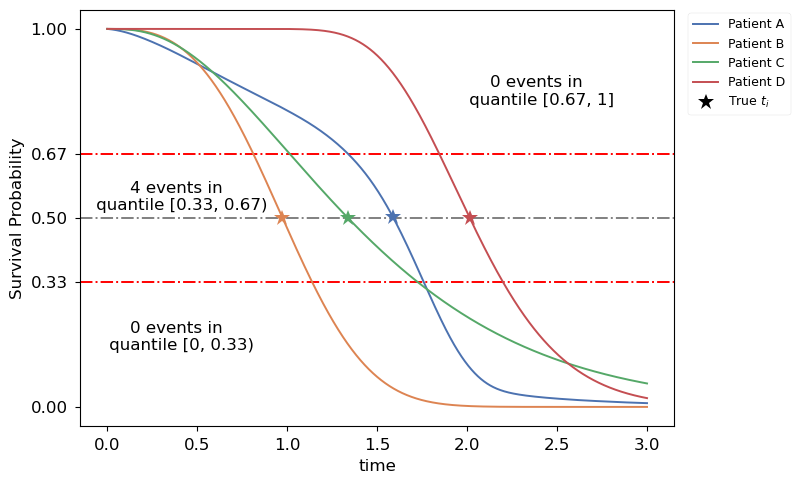

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz
import math
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as mlines

# import matplotlib.image as image
# from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
#
# death_img_file = "Figs/illustration/death.png"
# death_img = image.imread(death_img_file)
# death_imagebox = OffsetImage(death_img, zoom = 0.02)

color_list = sns.color_palette("deep", 6)

plt.style.use('seaborn-paper')
plt.rcParams["figure.figsize"] = (7, 5)
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)  # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

plt.rcParams['font.size'] = 12


def weibull_pdf(x, scale, shape):
    return (shape / scale) * (x / scale) ** (shape - 1) * np.exp(-(x / scale) ** shape)


def gamma_pdf(x, scale, shape):
    return (x ** (shape - 1) * np.exp(-x / scale)) / (math.gamma(shape) * scale ** shape)


def lognormal_pdf(x, mu, sigma):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))


def heaviside(x, time):
    function = np.zeros_like(x)
    function[x < time] = 1
    return function


e_1 = 1.588
e_2 = 0.973
e_3 = 1.335
e_4 = 2.014
end_time = 3
N = 100000
s1 = 1.2 * np.random.weibull(a=1.5, size=int(0.4 * N))  # generate your data sample with N elements
s2 = 1.8 * np.random.weibull(a=8, size=int(0.6 * N))
sample_all = np.append(s1, s2)
kde = gaussian_kde(sample_all)
# these are the values over which your kernel will be evaluated
dist_space = np.arange(0, end_time, 0.001)
p_1 = kde(dist_space)
# plt.plot( dist_space, pdf )
cdf_1 = cumtrapz(p_1, dist_space, initial=0)
death_idx_1 = int(e_1 / 0.001)
# ab_1 = AnnotationBbox(death_imagebox, (e_1, 1 - cdf_1[death_idx_1]), frameon = False)

p_2 = weibull_pdf(dist_space, 1.1, 3)
cdf_2 = cumtrapz(p_2, dist_space, initial=0)
death_idx_2 = int(e_2 / 0.001)
p_3 = gamma_pdf(dist_space, 0.5, 3)
cdf_3 = cumtrapz(p_3, dist_space, initial=0)
death_idx_3 = int(e_3 / 0.001)
p_4 = lognormal_pdf(dist_space, 0.7, 0.2)
p_4[0] = 0
cdf_4 = cumtrapz(p_4, dist_space, initial=0)
death_idx_4 = int(e_4 / 0.001)

fig, axes = plt.subplots()


# subfigure 5, d-calibration
axes.axhline(0.5, ls='dashdot', c='grey')
axes.axhline(0.33, ls='dashdot', c='red')
axes.axhline(0.67, ls='dashdot', c='red')
axes.plot(dist_space, 1 - cdf_1, label='Patient A', c=color_list[0])
axes.plot(dist_space, 1 - cdf_2, label='Patient B', c=color_list[1])
axes.plot(dist_space, 1 - cdf_3, label='Patient C', c=color_list[2])
axes.plot(dist_space, 1 - cdf_4, label='Patient D', c=color_list[3])
axes.plot(e_1, 1 - cdf_1[death_idx_1], marker='*', markersize=12, c=color_list[0])
axes.plot(e_2, 1 - cdf_2[death_idx_2], marker='*', markersize=12, c=color_list[1])
axes.plot(e_3, 1 - cdf_3[death_idx_3], marker='*', markersize=12, c=color_list[2])
axes.plot(e_4, 1 - cdf_4[death_idx_4], marker='*', markersize=12, c=color_list[3])
axes.text(2.4, 0.8, '0 events in \n quantile [0.67, 1]', fontsize=12, horizontalalignment='center')
axes.text(0.4, 0.52, '4 events in \n quantile [0.33, 0.67)', fontsize=12, horizontalalignment='center')
axes.text(0.4, 0.15, '0 events in \n quantile [0, 0.33)', fontsize=12, horizontalalignment='center')

axes.grid(False)
# axes[1, 2].spines.set_color('black')
axes.set_ylim([-0.05, 1.05])
# axes.set_title('(f) Distribution Calibration')
axes.set_xlabel('time')
axes.set_ylabel('Survival Probability')
axes.set_yticks([0, 0.33, 0.5, 0.67, 1])

lines, labels = axes.get_legend_handles_labels()
black_star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                           markersize=12, label='True t')
black_trangle = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
                              markersize=10, label='Predict t')

lines.append(black_star)
labels.append(r'True $t_i$')
lgd = fig.legend(lines, labels, bbox_to_anchor=(1.15, 0.97), prop={'size': 9})

# plt.axhline(0.5, ls='--', c='grey')
# plt.legend()
plt.tight_layout()

# plt.show()
plt.savefig('Figs/illustration/mae_vs_dcal.pdf', dpi=400, bbox_extra_artists=(lgd,), bbox_inches='tight')

